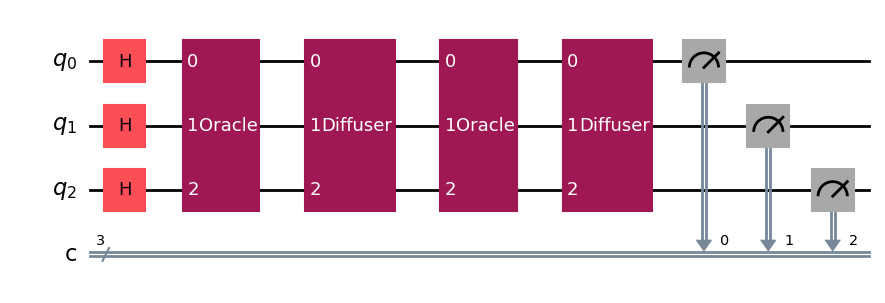


Measurement outcomes: {'001': 5, '000': 9, '110': 980, '011': 8, '100': 5, '010': 8, '101': 1, '111': 8}


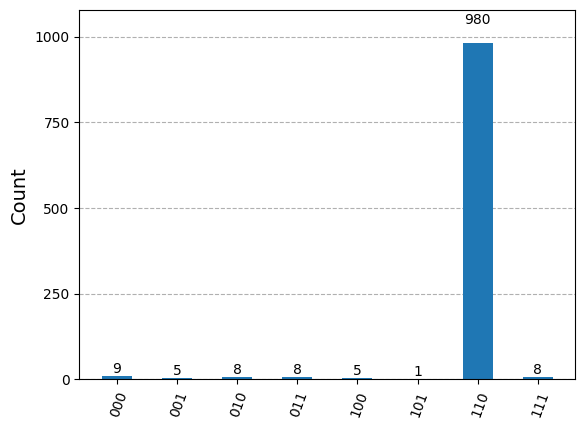

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import numpy as np

def create_oracle(n_qubits: int, marked_state: str) -> QuantumCircuit:
    """
    Creates the oracle circuit that flips the phase of the marked state.
    
    Args:
        n_qubits (int): Number of qubits in the search space.
        marked_state (str): The binary string (e.g. '110') representing the "solution" state.
    
    Returns:
        QuantumCircuit: A circuit implementing the oracle.
    
    Explanation:
        The oracle checks if the qubits match the marked pattern. If they do,
        it multiplies the amplitude of that state by -1 (a "phase flip").
        This step is central to Grover's algorithm because it tells the quantum
        computer which state is the special one we're trying to find.
    """
    oracle_circuit = QuantumCircuit(n_qubits, name="Oracle")

    # For each qubit, apply an X if the marked_state has a '0' in that position.
    # This sets us up to flip only the specific 'marked' state when we use a Z gate.
    for i, bit in enumerate(marked_state[::-1]): # Qiskit least significant qubit is on top wire
        if bit == '0':
            oracle_circuit.x(i)

    # Apply a multi-controlled Z gate
    oracle_circuit.h(n_qubits - 1)
    oracle_circuit.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    oracle_circuit.h(n_qubits - 1)

    # Reverse the earlier X gates.
    for i, bit in enumerate(marked_state[::-1]):
        if bit == '0':
            oracle_circuit.x(i)

    return oracle_circuit


def create_diffuser(n_qubits: int) -> QuantumCircuit:
    """
    Creates the diffuser (inversion-about-the-mean) circuit.
    
    Args:
        n_qubits (int): Number of qubits.
    
    Returns:
        QuantumCircuit: A circuit implementing the diffuser operator.
    
    Explanation:
        The diffuser is like "reflecting" all amplitudes about their average value.
        This pushes amplitude away from unmarked states and increases amplitude 
        for the marked state, making it more likely to appear when we measure.
    """
    diffuser_circuit = QuantumCircuit(n_qubits, name="Diffuser")

     # Apply Hadamard gates to all qubits
    diffuser_circuit.h(range(n_qubits))
    
    # Apply X gates to all qubits
    diffuser_circuit.x(range(n_qubits))

    # Apply a multi-controlled Z (similar to the oracle's controlled operation)
    diffuser_circuit.h(n_qubits - 1)
    diffuser_circuit.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    diffuser_circuit.h(n_qubits - 1)

    # Apply X to all qubits again
    diffuser_circuit.x(range(n_qubits))

    # Apply Hadamard gates to all qubits again
    diffuser_circuit.h(range(n_qubits))

    return diffuser_circuit


def grover_search(n_qubits: int, marked_state: str, num_iterations: int) -> QuantumCircuit:
    """
    Constructs the full Grover's algorithm circuit for a given marked state and 
    specified number of iterations.
    
    Args:
        n_qubits (int): Number of qubits.
        marked_state (str): The binary string representing the marked solution.
        num_iterations (int): Number of Grover iterations to perform.
    
    Returns:
        QuantumCircuit: The complete Grover circuit ready to be executed.
    
    Explanation:
        1. We start by putting all qubits into an equal superposition (so each 
           of the basis states is equally likely).
        2. Then we repeat the "Oracle" + "Diffuser" steps a certain number of times
           (num_iterations). Each repetition makes the marked state more and more 
           likely to appear.
        3. At the end, we measure to see which state we get. With enough iterations, 
           we usually get the marked state with high probability.
    """
    circuit = QuantumCircuit(n_qubits, n_qubits)

    # Initialize qubits to an equal superposition state
    circuit.h(range(n_qubits))

    # Create and append the oracle and diffuser once, 
    # then repeat them the required number of iterations.
    oracle = create_oracle(n_qubits, marked_state)
    diffuser = create_diffuser(n_qubits)

    for _ in range(num_iterations):
        circuit.append(oracle, range(n_qubits))
        circuit.append(diffuser, range(n_qubits))

    # Measure all qubits
    circuit.measure(range(n_qubits), range(n_qubits))

    return circuit


# Example usage:
if __name__ == "__main__":
    # Number of qubits (and thus items is 2^3 = 8)
    N_QUBITS = 3

    # Marked state: '110' (decimal 6)
    MARKED_STATE = '110'

    # The "optimal" number of iterations is approximately pi/4 * sqrt(2^n) = ~2 for 3 qubits.
    num_iterations = int(np.floor(np.pi / 4 * np.sqrt(2**N_QUBITS)))
 
    # Build the Grover's algorithm circuit
    grover_circuit = grover_search(N_QUBITS, MARKED_STATE, num_iterations)
   
    # Draw the circuit for visual reference
    display(grover_circuit.draw("mpl"))

    # Run the circuit on a simulator
    simulator = Aer.get_backend('aer_simulator')
    transpiled_circ = transpile(grover_circuit, simulator)
    job = simulator.run(transpiled_circ, shots=1024)
    result = job.result()

    # Get the counts (the number of times each state was measured)
    counts = result.get_counts(transpiled_circ)
    print("\nMeasurement outcomes:", counts)

    # Display a histogram of the results
    display(plot_histogram(counts))

